# EDA for Dropped California Fire Data

Modules: N/A <br>
Author: Joy McGillin <br>
Email: jmcgillin@berkeley.edu <br>
Date created: February 12, 2023 <br>

**Citations (data sources)**

``CA fires data:``
1. CAL Fire: Fire perimeters database: https://frap.fire.ca.gov/mapping/gis-data/
2. Data dictionary: https://frap.fire.ca.gov/frap-projects/fire-perimeters/

Layer 0 - accidental wildfires
Layer 1 - prescribed fires 
Layer 2 - non-prescribed fire fuel reduction projects

``Shapefiles for California ZIP codes (2010 census):``

Note: CAL Fire also has county bounderies info (check it here: https://frap.fire.ca.gov/mapping/gis-data/)

3. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=ZIP+Code+Tabulation+Areas

4. How to find if a point is inside a polygon:<br>
https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon <br>
https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff
    
**Citations (persons)**
1. N/A

**Preferred environment**
1. Code written in Jupyter Notebooks

### Step 1: Import packages

In [1]:
# standard
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates


# geospatial
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon

# ignore warnings
import warnings
warnings.filterwarnings(
    'ignore'
)

ModuleNotFoundError: ignored

### Step 2: Read cleaned data

```read data```

In [2]:
# read in the cleaned data and set index
data = pd.read_csv('fires_dropped.csv', index_col='Index')

FileNotFoundError: ignored

In [ ]:
data.shape

In [ ]:
data.sample(5)

In [ ]:
data.describe()

,CAUSE,GIS_ACRES,Shape_Length,Shape_Area
count,12660.000000,12681.000000,12681.000000,1.268100e+04
mean,10.960190,1485.206300,8514.019007,6.010417e+06
std,4.492174,5872.519452,13442.210862,2.376524e+07
min,1.000000,0.023172,38.844481,9.377280e+01
25%,9.000000,68.165733,2350.052302,2.758569e+05
50%,14.000000,272.298706,4869.561822,1.101954e+06
75%,14.000000,803.123474,9170.611742,3.250125e+06
max,18.000000,219999.281250,422177.849037,8.903055e+08


In [ ]:
print(data.isnull().sum())

FIRE_NAME         102
ALARM_DATE       5361
CONT_DATE       12666
CAUSE              21
GIS_ACRES           0
Shape_Length        0
Shape_Area          0
geometry            0
dtype: int64


In [ ]:
data['GIS_ACRES'] = data['GIS_ACRES'].astype(int)

In [ ]:
data[data['GIS_ACRES'] < 1000].count()

FIRE_NAME       9867
ALARM_DATE      5774
CONT_DATE         11
CAUSE           9944
GIS_ACRES       9962
Shape_Length    9962
Shape_Area      9962
geometry        9962
dtype: int64

In [ ]:
data[data['GIS_ACRES'] > 1000].count()

FIRE_NAME       2710
ALARM_DATE      1545
CONT_DATE          4
CAUSE           2714
GIS_ACRES       2717
Shape_Length    2717
Shape_Area      2717
geometry        2717
dtype: int64

In [ ]:
11087/(11087+1594)

0.8743001340588281

In [ ]:
9962/(9962+2717)

0.7857086521019008

87% of the dropped wildfires were relatively small, burning less than 2000 acres. 79% burned less than 1000 acres.

<AxesSubplot: ylabel='Density'>

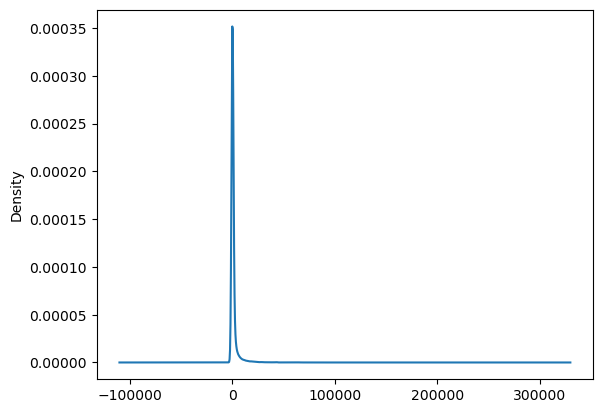

In [ ]:
data['GIS_ACRES'].plot.kde()

<AxesSubplot: ylabel='Frequency'>

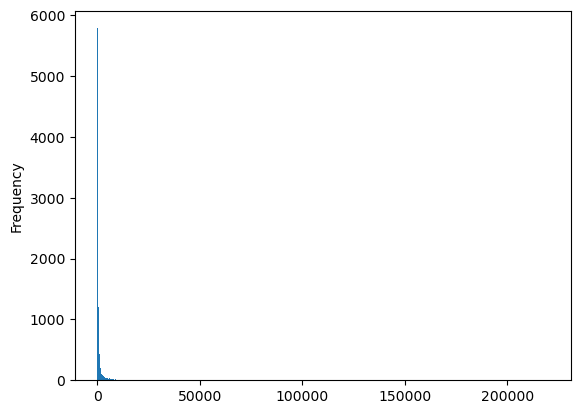

In [ ]:
data['GIS_ACRES'].plot.hist(bins=1000)

(0.0, 10000.0)

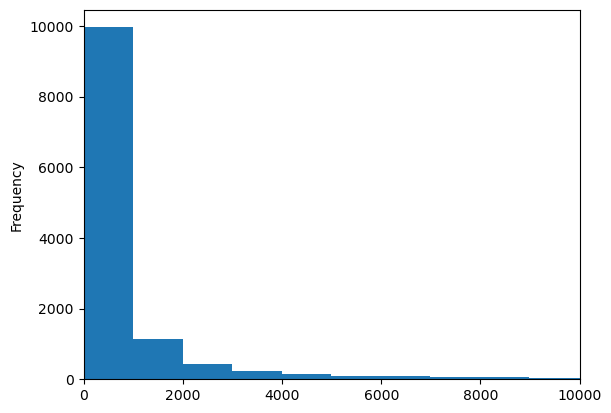

In [ ]:
# plot fires less than 50,000 acres 
bulkacres = data[data.GIS_ACRES < 20000]
bulkacres['GIS_ACRES'].plot.hist(bins=20)
plt.xlim(0,10000)
#plt.ylim(0,1000)

<AxesSubplot: >

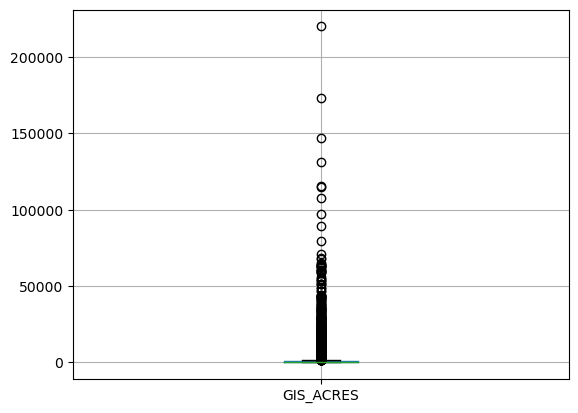

In [ ]:
data.boxplot(column='GIS_ACRES')

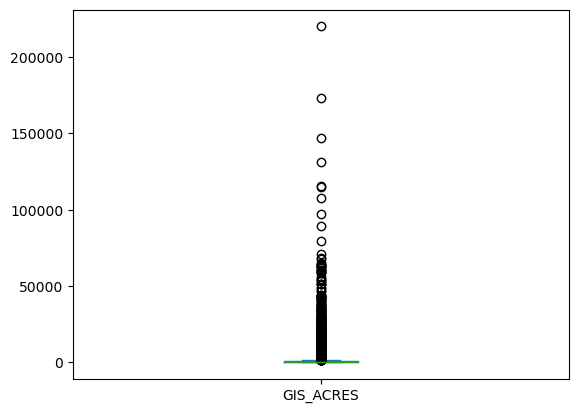

In [ ]:
data['GIS_ACRES'].plot(kind='box');

In [ ]:
outliers = data[data.GIS_ACRES > 10000]
outliers.sort_values(by=['GIS_ACRES'], ascending=False)

,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,geometry
Index,,,,,,,,
10877,MATILIJA,1932-09-07T00:00:00,NaN,9.0,219999,186772.299449,8.903055e+08,MULTIPOLYGON (((63709.42760000005 -375856.8666...
9787,MARBLE-CONE,1977-08-01T00:00:00,NaN,9.0,173333,155413.869051,7.014556e+08,MULTIPOLYGON (((-147588.2274999991 -181490.779...
10684,GLASS MOUNTAIN,1910-07-13T00:00:00,NaN,1.0,146967,156400.195026,5.947566e+08,MULTIPOLYGON (((-126800.7558000013 368285.0678...
11102,CAMPBELL,1990-08-13T00:00:00,NaN,2.0,131504,116419.388456,5.321787e+08,MULTIPOLYGON (((-144997.8052999992 242012.8068...
8542,CLAMPITT FIRE,1970-09-25T00:00:00,NaN,11.0,115537,422177.849037,4.675634e+08,MULTIPOLYGON (((96735.14589999989 -410459.4325...
...,...,...,...,...,...,...,...,...
11333,,NaN,NaN,9.0,10161,29660.269069,4.112208e+07,MULTIPOLYGON (((-19791.07239999995 -334028.599...
1940,,NaN,NaN,14.0,10110,39027.058788,4.091477e+07,MULTIPOLYGON (((295350.4677000009 -474822.8097...
7081,,NaN,NaN,14.0,10058,51653.656115,4.070362e+07,MULTIPOLYGON (((-36074.4748999998 60081.384099...


The 5 largest dropped wildfires all occured before or during 1990